In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])

# Download and load training data
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load test data
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]


In [2]:
classes = test_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


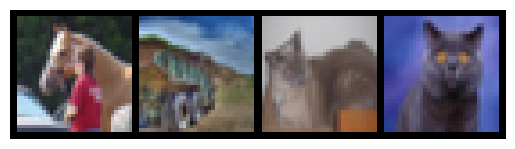

horse truck cat   cat  


In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

images_to_show = images[:4]
labels_to_show = labels[:4]

# Show images
imshow(torchvision.utils.make_grid(images_to_show))

# Print class labels
print(' '.join(f'{classes[labels_to_show[j]]:5s}' for j in range(4)))

# Custom CNN Block

In [4]:
class MyConv2D(nn.Module) :
    def __init__(self, in_ch, out_ch, ker_size, stride=1, padding=0) :
        """
        One convolutional block.
        Parameters:
        - in_ch: input dim
        - out_ch: output dim
        - ker_size: kernel size
        - stride: stride (default=1)
        - padding: padding (default=0)
        """
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch

        
        # Check if ker_size, stride, padding are given as integers or matrices
        if isinstance(ker_size, int) :
            ker_size = (ker_size, ker_size)
        if isinstance(stride, int) :
            stride = (stride, stride)
        if isinstance(padding, int) :
            padding = (padding, padding)

        self.ker_size = ker_size
        self.stride = stride
        self.padding = padding

        # He initialization
        self.weight = nn.Parameter(torch.randn(
          out_ch, in_ch, *ker_size  
        ) * (1.0 / (in_ch * ker_size[0] * ker_size[1])**0.5))

        self.bias = nn.Parameter(torch.zeros(out_ch))

    def forward(self, x) :
        device = x.device
        
        B, C, H, W = x.shape
        kh, kw = self.ker_size

        # Shape: (B, in_ch * kh * kw, L), where L = number of patches
        x_unf = F.unfold(x, kernel_size=self.ker_size, stride=self.stride, padding=self.padding)

        # Reshape weights to (out_ch, in_ch * kh * kw)
        weight_flat = self.weight.view(self.out_ch, -1).to(device)

        out_unf = weight_flat @ x_unf  # shape: (B, out_ch, L)
        out_unf = out_unf + self.bias.view(1, -1, 1).to(device)

        out_h = (H + 2*self.padding[0] - kh) // self.stride[0] + 1
        out_w = (W + 2*self.padding[1] - kw) // self.stride[1] + 1

        out = out_unf.view(B, self.out_ch, out_h, out_w)
        return out

# Custom Entropy Loss

In [5]:
class MyCrossEntropyLoss(nn.Module) :
    def __init__(self) :
        super().__init__()

    def forward(self, logits, targets) :
        # logits: (N, C)
        # targets: (N,)
        log_probs = F.log_softmax(logits, dim=1)
        loss = -log_probs[torch.arange(logits.size(0)), targets]
        return loss.mean()

# Custom SGD Optimizer

In [6]:
class MySGD(Optimizer) :
    def __init__(self, params, lr=0.01) :
        self.params = list(params)
        self.lr = lr

    def step(self, closure=None) :
        for p in self.params :
            if p.grad is not None :
                with torch.no_grad() :
                    p -= self.lr * p.grad

    def zero_grad(self) :
        for p in self.params :
            if p.grad is not None :
                p.grad.zero_()

# Custom CNN Model

In [7]:
class MyModel(nn.Module) :
    def __init__(self) :
        """
        3 layers of convolutional blocks, each with kernel size of 3 and followed by batch normalization.
        - conv1: (1, 4)
        - conv2: (4, 8)
        - conv3: (8, 16)
        """
        super().__init__()
        self.conv1 = MyConv2D(3, 32, ker_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = MyConv2D(32, 64, ker_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = MyConv2D(64, 128, ker_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2) # Halves H, W

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x) :
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (B, 32, 16, 16)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (B, 64, 8, 8)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # (B, 128, 4, 4)
        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyModel().to(device)
loss_fn = MyCrossEntropyLoss()
optimizer = MySGD(model.parameters(), lr=0.01)

In [9]:
num_epochs = 50

for epoch in range(num_epochs) :
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader) :
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        total_train_correct = (preds==y_batch).sum().item()
        total_train_samples = y_batch.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = total_train_correct / total_train_samples

    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    total_val_samples = 0

    with torch.no_grad() :
        for x_val, y_val in test_loader :
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            val_logits = model(x_val)
            val_loss = loss_fn(val_logits, y_val)
            total_val_loss += val_loss.item()

            val_preds = torch.argmax(val_logits, dim=1)
            total_val_correct += (val_preds==y_val).sum().item()
            total_val_samples += y_val.size(0)

    avg_val_loss = total_val_loss / len(test_loader)
    val_acc = total_val_correct / total_val_samples

    print(f"Epoch {epoch+1}")
    print(f"    Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"    Valid Loss: {avg_val_loss:.4f} | Valid Acc: {val_acc:.4f}")
    print("-" * 50)

Epoch 1
    Train Loss: 1.6368 | Train Acc: 0.5000
    Valid Loss: 1.4086 | Valid Acc: 0.4904
--------------------------------------------------
Epoch 2
    Train Loss: 1.3061 | Train Acc: 0.6250
    Valid Loss: 1.8072 | Valid Acc: 0.4055
--------------------------------------------------
Epoch 3
    Train Loss: 1.1432 | Train Acc: 0.5625
    Valid Loss: 1.3025 | Valid Acc: 0.5422
--------------------------------------------------
Epoch 4
    Train Loss: 1.0408 | Train Acc: 0.5625
    Valid Loss: 1.0617 | Valid Acc: 0.6255
--------------------------------------------------
Epoch 5
    Train Loss: 0.9671 | Train Acc: 0.5000
    Valid Loss: 0.9627 | Valid Acc: 0.6598
--------------------------------------------------
Epoch 6
    Train Loss: 0.9037 | Train Acc: 0.7500
    Valid Loss: 0.9513 | Valid Acc: 0.6643
--------------------------------------------------
Epoch 7
    Train Loss: 0.8528 | Train Acc: 0.9375
    Valid Loss: 0.9888 | Valid Acc: 0.6466
------------------------------------